# Index

1. [Zernike Moments](#zernike-moments)
2. [Fourier Descriptors](#fourier-descriptors)
3. [HOG Features](#hog-features)
4. [SIFT Descriptors](#sift-descriptors)

In [1]:
import numpy as np
import cv2
from sklearn.preprocessing import normalize
from scipy.spatial.distance import euclidean, cosine
import os

FIXED_SIZE = (128,128)

In [2]:
from matplotlib import pyplot as plt

def display_image(img, title="image"):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

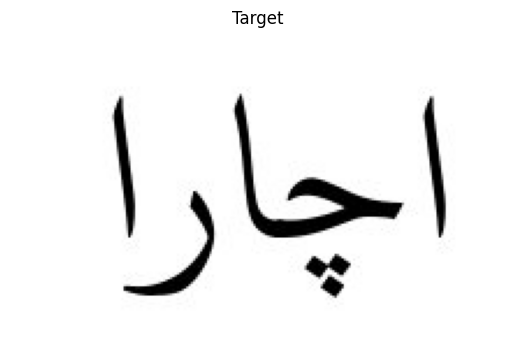

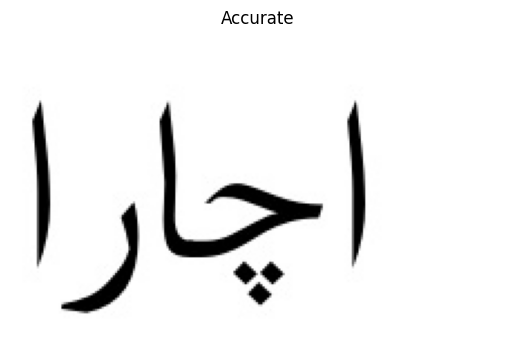

In [5]:
target = cv2.imread("sample2.jpg")
closest = cv2.imread("samplewords/acara.png")

display_image(target, "Target")
display_image(closest, "Accurate")

---

## Zernike Moments

In [6]:
#Compare distance conveniently
def compare_distances(sample, image_folder, func):
    min_distance = float('inf')
    closest_image_path = None
    closest_image_filename = None

    for image_file in os.listdir(image_folder):
        if image_file.endswith(".jpg") or image_file.endswith(".png"):
            image_path = os.path.join(image_folder, image_file)
            image = cv2.imread(image_path)
            currdistance = func(sample, image)
            
            if currdistance < min_distance:
                min_distance = currdistance
                closest_image_path = image_path
                closest_image_filename = os.path.splitext(image_file)[0]
    
    if closest_image_path is None:
        raise ValueError("No valid images found in specified folder.")

    return min_distance, closest_image_filename, rumijawi_dict.get(closest_image_filename)

In [7]:
#Make new dictionary
import pandas as pd
import os
["closest_image_filename"]
tsv_file = "rumi-jawi.tsv"
tsv_data = pd.read_csv(tsv_file, delimiter="\t", header=None, names=["rumi", "jawi"])
tsv_dict = dict(zip(tsv_data["rumi"], tsv_data["jawi"]))

images_folder = "samplewords"
image_filenames = [os.path.splitext(filename)[0] for filename in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, filename))]
image_set = set(image_filenames)

rumijawi_dict = {rumi:tsv_dict[rumi] for rumi in image_set if rumi in tsv_dict}

In [8]:
import cv2
import numpy as np
import mahotas

def compute_zernike_moments(image, radius=21, degree=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    zernike_moments = mahotas.features.zernike_moments(binary, radius, degree)
    return zernike_moments

def compare_images_zernike(image1, image2):
    moments1 = compute_zernike_moments(image1)
    moments2 = compute_zernike_moments(image2)

    distance = np.linalg.norm(moments1 - moments2)

    return distance

In [9]:
sample = cv2.imread("sample2.jpg") #acara

compare_distances(sample, "samplewords", compare_images_zernike)

#Not even remotely similar.

(0.06738205515365461, 'berkempen', 'برکيمڤين')

## Fourier Descriptors

In [10]:
def compute_fourier_descriptors(image, num_descriptors=10):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.zeros(num_descriptors)
    contour = max(contours, key=cv2.contourArea)

    contour_x = contour[:, 0, 0]
    contour_y = contour[:, 0, 1]
    contour_complex = contour_x + 1j * contour_y

    fourier_result = np.fft.fft(contour_complex)
    descriptors = np.abs(fourier_result[:num_descriptors])
    descriptors /= descriptors[0]

    if len(descriptors) < num_descriptors:
        descriptors = np.pad(descriptors, (0, num_descriptors - len(descriptors)), 'constant')

    return descriptors

def compare_images_fourier(image1, image2):
    descriptor1 = compute_fourier_descriptors(image1)
    descriptor2 = compute_fourier_descriptors(image2)

    distance = np.linalg.norm(descriptor1 - descriptor2)

    return distance

In [11]:
sample = cv2.imread("sample2.jpg")

compare_distances(sample, "samplewords", compare_images_fourier)

#Slightly closer than before...

(0.0008480133395311198, 'antik', 'انتيک')

## HOG Features

In [12]:
from skimage.feature import hog

def compute_hog_descriptors(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=False)
    return hog_features

def compare_images_hog(image1, image2):
    image1_resized = cv2.resize(image1, (image2.shape[1], image2.shape[0]))

    descriptors1 = compute_hog_descriptors(image1_resized)
    descriptors2 = compute_hog_descriptors(image2)

    distance = np.linalg.norm(descriptors1-descriptors2)

    return distance

In [13]:
compare_distances(sample, "samplewords", compare_images_hog)

# Takes a very long time.

(13.56349445639542, 'ada', 'اد')

## SIFT Descriptors

In [14]:
def compute_sift_descriptors(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return keypoints, descriptors

def compare_image_sift(image1, image2):
    _, descriptors1 = compute_sift_descriptors(image1)
    _, descriptors2 = compute_sift_descriptors(image2)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    similarity_ratio = len(good_matches) / len(matches) if matches else 0

    #distance = len(good_matches)

    #return distance

    return similarity_ratio

In [15]:
compare_distances(sample, "samplewords", compare_image_sift)

#Doesn't seem to work that well. No need to use SIFT.

(0.0, 'xerostomia', 'زيروستوميا')